# Preprocessing for Final Dataset
## Set up environment

In [89]:
import os
import pandas as pd
import numpy as np
import statistics
import re
from fuzzywuzzy import process, fuzz

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize the stop words
stop_words = set(stopwords.words('english'))

# vectorizing the book info column using TFidf Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import KBinsDiscretizer

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/caseyhaseloff/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/caseyhaseloff/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/caseyhaseloff/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/caseyhaseloff/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Pull in required data:

In [157]:
path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/")

os.listdir(path + 'cleaned/')

['.DS_Store',
 'BX-Books.csv',
 'BX-Ratings.csv',
 'BX-Users.csv',
 'BX-NewBooksRatings.csv',
 '.ipynb_checkpoints']

In [158]:
books = pd.read_csv(path + 'cleaned/BX-Books.csv')
users = pd.read_csv(path + 'cleaned/BX-Users.csv')
ratings = pd.read_csv(path + 'cleaned/BX-Ratings.csv')

In [159]:
books.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,richard bruce wright,harperflamingo canada,clara callan,clara callan by richard bruce wright,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8


In [160]:
ratings.head(1)

,User-ID,ISBN,Book-Rating
0,276744,038550120X,7


In [161]:
users.head(1)

,User-ID,User-City,User-State,User-Country,User-Age,Age-Group,User-Info,User-Country-Encoded,User-Info-Encoded,Age-Group-Encoded
0,8,timmins,ontario,canada,13.0,"(4.0, 26.0]",timmins_ontario_canada,17,11421,0


## Discretize book ratings

array([[<Axes: title={'center': 'Book-Rating'}>]], dtype=object)

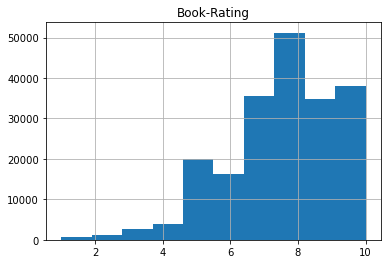

In [162]:
# ratings are skewed towards higher
# users are more likely to leave a nice review
ratings.hist('Book-Rating')

## Country only
Only include country in user information
#### Create feature that states the popularity of a book:
Since some books have more reviews this will be taken into consideration for popularity. While also taking in the average rating of a book

In [163]:
df = ratings.merge(users)

In [164]:
df.head(1)

,User-ID,ISBN,Book-Rating,User-City,User-State,User-Country,User-Age,Age-Group,User-Info,User-Country-Encoded,User-Info-Encoded,Age-Group-Encoded
0,276744,038550120X,7,torrance,california,usa,59.0,"(46.0, 100.0]",torrance_california_usa,124,11481,3


In [165]:
weighted_ratings = df.groupby(['ISBN', 'User-Country', 'User-Country-Encoded', 'Age-Group-Encoded', 'Age-Group']).agg(average_rating 
                                     = ('Book-Rating', 'mean'), times_read = ('User-ID', 'count'), average_age = ('User-Age', 'mean')) \
                                    .reset_index()

In [166]:
weighted_ratings

,ISBN,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age
0,0002005018,canada,17,0,"(4.0, 26.0]",7.333333,3,20.333333
1,0002005018,canada,17,1,"(26.0, 34.0]",7.666667,3,29.000000
2,0002005018,canada,17,3,"(46.0, 100.0]",7.000000,1,60.000000
3,0002005018,unknown,121,0,"(4.0, 26.0]",8.000000,1,26.000000
4,0002116286,canada,17,0,"(4.0, 26.0]",8.000000,1,20.000000
...,...,...,...,...,...,...,...,...
88868,9812327975,unknown,121,0,"(4.0, 26.0]",7.000000,1,26.000000
88869,9871138148,germany,41,1,"(26.0, 34.0]",9.000000,1,33.000000
88870,9871138148,portugal,89,2,"(34.0, 46.0]",9.000000,1,41.000000
88871,9871138148,spain,102,0,"(4.0, 26.0]",8.000000,2,20.000000


In [167]:
read_books = weighted_ratings.groupby('ISBN')['times_read'].sum()

# books that have are in the top 20% of times read
books_over = read_books[read_books > np.quantile(list(read_books), q = 0.8)].index

In [168]:
weighted_ratings = weighted_ratings[weighted_ratings['ISBN'].isin(books_over)]
# top amount of reviewed books 
weighted_ratings['ISBN'].nunique()

3334

In [169]:
m = np.quantile(list(weighted_ratings['times_read']), q = 0.8)
t = weighted_ratings['times_read']
a = weighted_ratings['average_rating']
c = ratings[ratings['ISBN'].isin(books_over)]['Book-Rating'].mean()

In [170]:
weighted_ratings['weighted_ratings'] = ((t*a/(t+m))) + ((m*c/(m+t)))

/var/folders/z5/2xfh619x3csdbh0bph8vb9100000gn/T/ipykernel_79207/1790009516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_ratings['weighted_ratings'] = ((t*a/(t+m))) + ((m*c/(m+t)))


In [171]:
weighted_ratings

,ISBN,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings
82,000649840X,australia,7,1,"(26.0, 34.0]",9.000000,1,32.000000,7.978563
83,000649840X,australia,7,2,"(34.0, 46.0]",8.000000,1,39.000000,7.811896
84,000649840X,canada,17,1,"(26.0, 34.0]",3.000000,1,30.000000,6.978563
85,000649840X,canada,17,2,"(34.0, 46.0]",7.000000,1,44.000000,7.645230
86,000649840X,hong kong,46,1,"(26.0, 34.0]",10.000000,1,34.000000,8.145230
...,...,...,...,...,...,...,...,...,...
88758,8845205118,unknown,121,1,"(26.0, 34.0]",10.000000,1,31.000000,8.145230
88781,884590184X,italy,55,0,"(4.0, 26.0]",6.833333,6,21.833333,7.261034
88782,884590184X,italy,55,1,"(26.0, 34.0]",8.428571,7,29.714286,8.155948
88783,884590184X,italy,55,2,"(34.0, 46.0]",9.000000,1,42.000000,7.978563


array([[<Axes: title={'center': 'weighted_ratings'}>]], dtype=object)

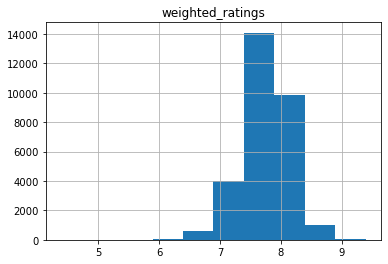

In [172]:
weighted_ratings.hist('weighted_ratings')

In [173]:
df = books.merge(weighted_ratings)

In [174]:
df.shape

(29627, 20)

In [175]:
df.sort_values('weighted_ratings', ascending = False).head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings
12752,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000.0,Scholastic,j k rowling,scholastic,harry potter and the goblet of fire book 4,harry potter and the goblet of fire book 4 by ...,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,usa,124,0,"(4.0, 26.0]",9.581395,43,19.348837,9.393154
12925,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003.0,Scholastic,j k rowling,scholastic,harry potter and the order of the phoenix book 5,harry potter and the order of the phoenix book...,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,usa,124,0,"(4.0, 26.0]",9.480000,50,20.920000,9.324934
12753,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000.0,Scholastic,j k rowling,scholastic,harry potter and the goblet of fire book 4,harry potter and the goblet of fire book 4 by ...,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,usa,124,1,"(26.0, 34.0]",9.500000,30,30.466667,9.253468
14195,0439136369,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2001.0,Scholastic,j k rowling,scholastic,harry potter and the prisoner of azkaban book 3,harry potter and the prisoner of azkaban book ...,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,usa,124,0,"(4.0, 26.0]",9.444444,36,20.611111,9.240765
9965,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999.0,Scholastic,j k rowling,scholastic,harry potter and the prisoner of azkaban book 3,harry potter and the prisoner of azkaban book ...,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7,usa,124,3,"(46.0, 100.0]",9.769231,13,51.230769,9.215077


In [176]:
df.sort_values('weighted_ratings', ascending = False).tail(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings
117,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,rich shapero,too far,wild animus,wild animus by rich shapero,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,usa,124,0,"(4.0, 26.0]",4.375000,64,21.390625,4.621324
120,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,rich shapero,too far,wild animus,wild animus by rich shapero,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,usa,124,3,"(46.0, 100.0]",4.269231,78,56.269231,4.480378
54,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,rich shapero,too far,wild animus,wild animus by rich shapero,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,canada,17,1,"(26.0, 34.0]",3.650000,20,30.600000,4.474855
44,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,rich shapero,too far,wild animus,wild animus by rich shapero,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,australia,7,2,"(34.0, 46.0]",2.909091,11,38.727273,4.429461
118,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,rich shapero,too far,wild animus,wild animus by rich shapero,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,usa,124,1,"(26.0, 34.0]",4.154930,71,30.380282,4.393044


## Labelling weighted ratings:

array([[<Axes: title={'center': 'weighted_ratings'}>]], dtype=object)

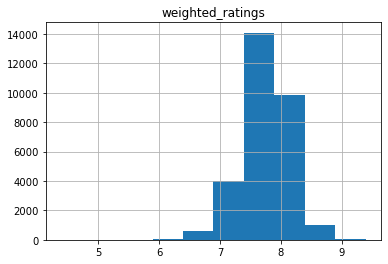

In [177]:
weighted_ratings.hist('weighted_ratings')

In [178]:
encoder = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

In [179]:
ratings_discretized = encoder.fit_transform(df[['weighted_ratings']])

In [180]:
encoder.bin_edges_

array([array([4.39304444, 7.64522961, 7.97856295, 9.3931537 ])],
      dtype=object)

In [181]:
df['weighted_ratings_group_encoded'] = ratings_discretized.astype(int)

In [182]:
df.groupby(['weighted_ratings_group_encoded'])['ISBN'].count()

weighted_ratings_group_encoded
0     8579
1    10488
2    10560
Name: ISBN, dtype: int64

In [183]:
df.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings,weighted_ratings_group_encoded
0,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,amy tan,putnam pub group,the kitchen god s wife,the kitchen god s wife by amy tan,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7,malaysia,65,0,"(4.0, 26.0]",10.0,1,21.0,8.14523,2


In [184]:
df.shape

(29627, 21)

In [185]:
df.to_csv(path + 'processed/processed_books_country.csv', index = False)

## Include City, State, Country encoding
#### Create feature that states the popularity of a book:
Since some books have more reviews this will be taken into consideration for popularity. While also taking in the average rating of a book

In [186]:
df = ratings.merge(users)

In [187]:
df.head(1)

,User-ID,ISBN,Book-Rating,User-City,User-State,User-Country,User-Age,Age-Group,User-Info,User-Country-Encoded,User-Info-Encoded,Age-Group-Encoded
0,276744,038550120X,7,torrance,california,usa,59.0,"(46.0, 100.0]",torrance_california_usa,124,11481,3


In [188]:
weighted_ratings = df.groupby(['ISBN', 'User-Country', 'User-Info', 'User-Info-Encoded', 'User-Country-Encoded', 'Age-Group-Encoded', 'Age-Group']).agg(average_rating 
                                     = ('Book-Rating', 'mean'), times_read = ('User-ID', 'count'), average_age = ('User-Age', 'mean')) \
                                    .reset_index()

In [189]:
weighted_ratings

,ISBN,User-Country,User-Info,User-Info-Encoded,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age
0,0002005018,canada,comber_ontario_canada,2520,17,0,"(4.0, 26.0]",8.0,1,24.0
1,0002005018,canada,fredericton_new brunswick_canada,3990,17,1,"(26.0, 34.0]",6.0,1,27.0
2,0002005018,canada,guelph_ontario_canada,4596,17,0,"(4.0, 26.0]",9.0,1,24.0
3,0002005018,canada,halifax_nova scotia_canada,4673,17,3,"(46.0, 100.0]",7.0,1,60.0
4,0002005018,canada,kingston_ontario_canada,5753,17,1,"(26.0, 34.0]",9.0,1,30.0
...,...,...,...,...,...,...,...,...,...,...
200919,9871138148,germany,cologne_unknown_germany,2474,41,1,"(26.0, 34.0]",9.0,1,33.0
200920,9871138148,portugal,amadora_lisboa_portugal,300,89,2,"(34.0, 46.0]",9.0,1,41.0
200921,9871138148,spain,barcelona_barcelona_spain,736,102,0,"(4.0, 26.0]",6.0,1,25.0
200922,9871138148,spain,castelldefels_barcelona_spain,1947,102,0,"(4.0, 26.0]",10.0,1,15.0


In [190]:
read_books = weighted_ratings.groupby('ISBN')['times_read'].sum()

# books that have are in the top 20% of times read
books_over = read_books[read_books > np.quantile(list(read_books), q = 0.8)].index

In [191]:
weighted_ratings = weighted_ratings[weighted_ratings['ISBN'].isin(books_over)]
weighted_ratings

,ISBN,User-Country,User-Info,User-Info-Encoded,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age
112,000649840X,australia,jan juc_victoria_australia,5462,7,2,"(34.0, 46.0]",8.0,1,39.0
113,000649840X,australia,sydney_new south wales_australia,11203,7,1,"(26.0, 34.0]",9.0,1,32.0
114,000649840X,canada,st. john`s_ontario_canada,10859,17,1,"(26.0, 34.0]",3.0,1,30.0
115,000649840X,canada,toronto_ontario_canada,11477,17,2,"(34.0, 46.0]",7.0,1,44.0
116,000649840X,hong kong,hong kong_unknown_hong kong,5130,46,1,"(26.0, 34.0]",10.0,1,34.0
...,...,...,...,...,...,...,...,...,...,...
200784,884590184X,italy,reggio emilia_emilia romagna_italy,9459,55,0,"(4.0, 26.0]",8.0,1,24.0
200785,884590184X,italy,roma_lazio_italy,9710,55,0,"(4.0, 26.0]",1.0,1,19.0
200786,884590184X,italy,rome_rome_italy,9718,55,3,"(46.0, 100.0]",8.0,1,57.0
200787,884590184X,italy,siena_toscana_italy,10456,55,0,"(4.0, 26.0]",10.0,1,26.0


In [192]:
m = np.quantile(list(weighted_ratings['times_read']), q = 0.8)
t = weighted_ratings['times_read']
a = weighted_ratings['average_rating']
c = ratings[ratings['ISBN'].isin(books_over)]['Book-Rating'].mean()

In [193]:
weighted_ratings['weighted_ratings'] = ((t*a/(t+m))) + ((m*c/(m+t)))

/var/folders/z5/2xfh619x3csdbh0bph8vb9100000gn/T/ipykernel_79207/1790009516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_ratings['weighted_ratings'] = ((t*a/(t+m))) + ((m*c/(m+t)))


In [194]:
weighted_ratings

,ISBN,User-Country,User-Info,User-Info-Encoded,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings
112,000649840X,australia,jan juc_victoria_australia,5462,7,2,"(34.0, 46.0]",8.0,1,39.0,7.887138
113,000649840X,australia,sydney_new south wales_australia,11203,7,1,"(26.0, 34.0]",9.0,1,32.0,8.387138
114,000649840X,canada,st. john`s_ontario_canada,10859,17,1,"(26.0, 34.0]",3.0,1,30.0,5.387138
115,000649840X,canada,toronto_ontario_canada,11477,17,2,"(34.0, 46.0]",7.0,1,44.0,7.387138
116,000649840X,hong kong,hong kong_unknown_hong kong,5130,46,1,"(26.0, 34.0]",10.0,1,34.0,8.887138
...,...,...,...,...,...,...,...,...,...,...,...
200784,884590184X,italy,reggio emilia_emilia romagna_italy,9459,55,0,"(4.0, 26.0]",8.0,1,24.0,7.887138
200785,884590184X,italy,roma_lazio_italy,9710,55,0,"(4.0, 26.0]",1.0,1,19.0,4.387138
200786,884590184X,italy,rome_rome_italy,9718,55,3,"(46.0, 100.0]",8.0,1,57.0,7.887138
200787,884590184X,italy,siena_toscana_italy,10456,55,0,"(4.0, 26.0]",10.0,1,26.0,8.887138


array([[<Axes: title={'center': 'weighted_ratings'}>]], dtype=object)

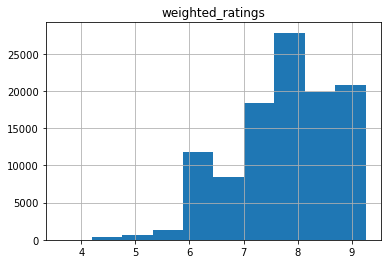

In [195]:
weighted_ratings.hist('weighted_ratings')

In [196]:
df = books.merge(weighted_ratings)

In [197]:
df.shape

(109393, 22)

In [198]:
df.sort_values('weighted_ratings', ascending = False).head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Info,User-Info-Encoded,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings
75017,0440212561,Outlander,DIANA GABALDON,1992.0,Dell,diana gabaldon,dell,outlander,outlander by diana gabaldon,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7,canada,ottawa_ontario_canada,8543,17,0,"(4.0, 26.0]",10.0,2,24.5,9.258092
11415,0156027321,Life of Pi,Yann Martel,2003.0,Harvest Books,yann martel,harvest books,life of pi,life of pi by yann martel,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,spain,barcelona_catalunya_spain,739,102,2,"(34.0, 46.0]",10.0,2,35.5,9.258092
38067,0060392452,Stupid White Men ...and Other Sorry Excuses fo...,Michael Moore,2002.0,Regan Books,michael moore,reganbooks,stupid white men and other sorry excuse for th...,stupid white men and other sorry excuse for th...,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,usa,charleston_west virginia_usa,2086,124,1,"(26.0, 34.0]",10.0,2,33.0,9.258092
28677,0385486804,Into the Wild,Jon Krakauer,1997.0,Anchor,jon krakauer,anchor,into the wild,into the wild by jon krakauer,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7,usa,cincinnati_ohio_usa,2255,124,0,"(4.0, 26.0]",10.0,2,20.0,9.258092
13568,0399144463,Who Moved My Cheese? An Amazing Way to Deal wi...,Spencer Johnson,1998.0,Putnam Pub Group (Paper),spencer johnson,putnam pub group paper,who moved my cheese an amazing way to deal wit...,who moved my cheese an amazing way to deal wit...,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7,usa,elsmere_kentucky_usa,3483,124,2,"(34.0, 46.0]",10.0,2,41.0,9.258092


In [199]:
df.sort_values('weighted_ratings', ascending = False).tail(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Info,User-Info-Encoded,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings
699,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,rich shapero,too far,wild animus,wild animus by rich shapero,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,usa,philadelphia_pennsylvania_usa,8881,124,0,"(4.0, 26.0]",2.0,2,21.0,3.924759
80891,0446608815,Pop Goes the Weasel,James Patterson,2000.0,Warner Vision,james patterson,warner vision,pop go the weasel,pop go the weasel by james patterson,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,canada,calgary_alberta_canada,1717,17,1,"(26.0, 34.0]",2.0,2,30.0,3.924759
358,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,rich shapero,too far,wild animus,wild animus by rich shapero,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,canada,winnipeg_manitoba_canada,12696,17,1,"(26.0, 34.0]",2.0,2,31.5,3.924759
449,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,rich shapero,too far,wild animus,wild animus by rich shapero,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,singapore,singapore_unknown_singapore,10492,97,1,"(26.0, 34.0]",2.0,2,29.0,3.924759
29971,0385492081,Into Thin Air : A Personal Account of the Mt. ...,JON KRAKAUER,1998.0,Anchor,jon krakauer,anchor,into thin air a personal account of the mt eve...,into thin air a personal account of the mt eve...,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7,usa,herkimer_new york_usa,4943,124,0,"(4.0, 26.0]",2.8,5,19.8,3.629046


## Labelling weighted ratings:

array([[<Axes: title={'center': 'weighted_ratings'}>]], dtype=object)

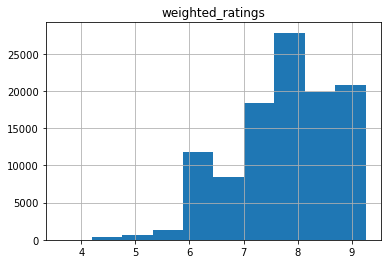

In [200]:
weighted_ratings.hist('weighted_ratings')

In [239]:
encoder = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

In [240]:
ratings_discretized = encoder.fit_transform(df[['weighted_ratings']])

In [241]:
encoder.bin_edges_

array([array([3.62904592, 7.38713777, 8.38713777, 9.25809185])],
      dtype=object)

In [242]:
df['weighted_ratings_group_encoded'] = ratings_discretized.astype(int)

In [243]:
df.groupby(['weighted_ratings_group_encoded'])['ISBN'].count()

weighted_ratings_group_encoded
0    22784
1    46324
2    40285
Name: ISBN, dtype: int64

In [244]:
df.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Info,User-Info-Encoded,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings,weighted_ratings_group_encoded
0,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,amy tan,putnam pub group,the kitchen god s wife,the kitchen god s wife by amy tan,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7,malaysia,kuala lumpur_selangor_malaysia,5841,65,0,"(4.0, 26.0]",10.0,1,21.0,8.887138,2


In [245]:
df.to_csv(path + 'processed/processed_books_info.csv', index = False)